In [1]:
import sys
sys.path.append("./MICCAI19-MedVQA")

import argparse
import torch
from torch.utils.data import DataLoader
import dataset_RAD
import base_model
import utils
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from bunch import Bunch
import numpy as np
import torchvision.transforms.functional as TF

data_RAD = './MICCAI19-MedVQA/data_RAD'
model_path = './MICCAI19-MedVQA/BAN_MEVF'
batch_size = 1
constructor = 'build_BAN'
rnn = 'LSTM'

torch.backends.cudnn.benchmark = True
device = torch.device("cuda")

dictionary = dataset_RAD.Dictionary.load_from_file(os.path.join(data_RAD , 'dictionary.pkl'))

# shitfix so it can work with their code
args = Bunch()
args.RAD_dir = data_RAD
args.autoencoder = True
args.maml = False
args.autoencoder = True
args.feat_dim = 64
args.op = 'c'
args.num_hid = 1024
args.rnn = rnn
args.gamma = 2
args.ae_model_path = 'pretrained_ae.pth'
args.maml_model_path = 'pretrained_maml.weights'
args.activation = 'relu'
args.dropout = 0.5
args.maml = True
args.eps_cnn = 1e-5
args.momentum_cnn = 0.05

loading dictionary from ./MICCAI19-MedVQA/data_RAD/dictionary.pkl


In [2]:
# in our case, eval_dset is useful just for getting some 
# parameters for the word embeddings and bi-attention.
eval_dset = dataset_RAD.VQAFeatureDataset('test', args, dictionary)
model = base_model.build_BAN(eval_dset, args)

loading MAML image data from file: ./MICCAI19-MedVQA/data_RAD/images84x84.pkl
loading DAE image data from file: ./MICCAI19-MedVQA/data_RAD/images128x128.pkl
load initial weights MAML from: ./MICCAI19-MedVQA/data_RAD/pretrained_maml.weights
load initial weights DAE from: ./MICCAI19-MedVQA/data_RAD/pretrained_ae.pth


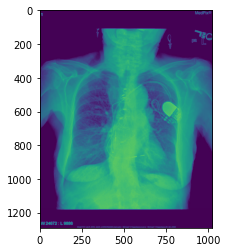

In [3]:
# Load image
xray = cv2.imread("./MICCAI19-MedVQA/data_RAD/images/synpic42202.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(xray)

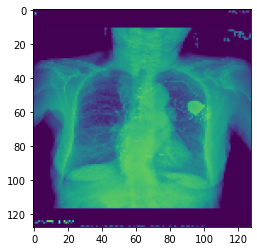

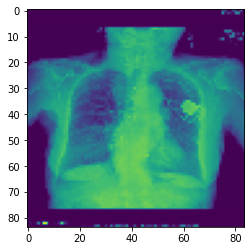

In [4]:
# Get image into the specific format for the VQA model
xray_ae = cv2.resize(xray, (128, 128))
xray_maml = cv2.resize(xray, (84, 84))
plt.imshow(xray_ae)
plt.show()
plt.imshow(xray_maml)
plt.show()

In [5]:
# xray_ae_t = torch.from_numpy(np.array(xray_ae)).type('torch.FloatTensor')
# xray_maml_t = torch.from_numpy(np.array(xray_maml)).type('torch.FloatTensor')

xray_ae_t = TF.to_tensor(np.array(xray_ae))
xray_maml_t = TF.to_tensor(np.array(xray_maml))

print(xray_ae_t.shape, xray_maml_t.shape)

torch.Size([1, 128, 128]) torch.Size([1, 84, 84])


In [6]:
# Let's put it together and convert them to tensors
def load_image_tensors(image_path):
    xray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    xray_ae = cv2.resize(xray, (128, 128))
    xray_maml = cv2.resize(xray, (84, 84))
    xray_ae_t = TF.to_tensor(np.array(xray_ae))
    xray_maml_t = TF.to_tensor(np.array(xray_maml))

    xray_maml_t = xray_maml_t.unsqueeze(1).to(device)
    xray_ae_t = xray_ae_t.unsqueeze(1).to(device)
    return [xray_maml_t, xray_ae_t]

In [7]:
image_tensors = load_image_tensors("./MICCAI19-MedVQA/data_RAD/images/synpic42202.jpg")

In [8]:
def tokenize(text, dataset, max_length=12):
    tokens = dataset.dictionary.tokenize(text, False)
    tokens = tokens[:max_length]
    if len(tokens) < max_length:
        # Note here we pad in front of the sentence
        padding = [dataset.dictionary.padding_idx] * (max_length - len(tokens))
        tokens = tokens + padding
    utils.assert_eq(len(tokens), max_length)
    tokens = torch.tensor([tokens]).to(device)
    return tokens

In [9]:
question = 'is there evidence of an aortic aneurysm ?'
tokens = tokenize(question, eval_dset)
print(tokens)

tensor([[   9,   10,   11,    2,   28,   29,   30, 1177, 1177, 1177, 1177, 1177]],
       device='cuda:0')


In [11]:
model_path = 'MICCAI19-MedVQA/saved_models/BAN_MEVF/model_epoch19.pth'
model_data = torch.load(model_path)

In [12]:
model = model.to(device)
model.load_state_dict(model_data.get('model_state', model_data))

<All keys matched successfully>

In [13]:
model.train(False)
features, _ = model(image_tensors, tokens)
logits = model.classifier(features)
prediction = torch.max(logits, 1)[1].data #argmax
eval_dset.label2ans[prediction.item()]

'no'